# Weight Normalization

One way to make deep networks easier to train is to use more sophisticated optimization procedures such as SGD+momentum, RMSProp, or Adam. Another strategy is to change the architecture of the network to make it easier to train. One idea along these lines is weight normalization which was proposed by [4] in 2016.

The idea is relatively straightforward. Machine learning methods tend to work better when their input data consists of uncorrelated features with zero mean and unit variance. When training a neural network, we can reparametrize the weights $w$ of the network in the following way

$$w = g \tfrac{v}{||v||}$$.

This formulation explicitly decorrelates the magnitude $g$ and direction $v$. This will ensure that the next layer of the network sees data that follows a nice distributio and even more during the training process the distribution of features at each layer of the network will not shift as the weights of each layer are updated.

The authors of [4] hypothesize that the reparametrization of the weights distribution of a deep neural networks may make training deep networks easier and faster.

It is possible that this normalization strategy could reduce the representational power of the network, since it may sometimes be optimal for certain layers to have features that are on substantially large scale difference. To this end, the weight normalization fixes the issue by learning the scale parameter $g$. It is updated by the same gradient descent optimization procedure as other the direction of the weight $v$.

[4][Tim Salimans, Diederik P. Kingma, "Weight Normalization: A Simple Reparameterization to Accelerate Training of Deep Neural Networks", OpenAI 2016.](https://arxiv.org/abs/1602.07868)


In [1]:
# As usual, a bit of setup
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

run the following from the cs231n directory and try again:
python setup.py build_ext --inplace
You may also need to restart your iPython kernel


In [2]:
# Load the (preprocessed) CIFAR10 data.
data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Affine weight normalized layer: foward
Open the file `cs231n/layers.py` and implement the `affine_wn_forward` function.

HINT: You might find it useful take advantage of your existing implementation of the `affine_forward` function and slightly modify it's inputs to suit your needs.

Once you are done you can test your implementation by running the following:

In [3]:
# Test the affine_wn_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
v = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)
g = np.linalg.norm(v)

out, _ = affine_wn_forward(x, v, b, g)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_wn_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_wn_forward function:
difference:  9.7698500479884e-10


# Affine weight normalized layer: backward
Now implement the `affine_wn_backward` function and test your implementation using numeric gradient checking.

HINT: You might find it useful use your existing implementation of the `affine_backward` function and reuse the gradients it outputs.

In [4]:
# Test the affine_wn_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
v = np.random.randn(6, 5)
b = np.random.randn(5)
g = np.random.randn(1)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_wn_forward(x, v, b, g)[0], x, dout)
dv_num = eval_numerical_gradient_array(lambda v: affine_wn_forward(x, v, b, g)[0], v, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_wn_forward(x, v, b, g)[0], b, dout)
dg_num = eval_numerical_gradient_array(lambda g: affine_wn_forward(x, v, b, g)[0], g, dout)

_, cache = affine_wn_forward(x, v, b, g)
dx, dv, db, dg = affine_wn_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dv error: ', rel_error(dv_num, dv))
print('db error: ', rel_error(db_num, db))
print('dg error: ', rel_error(dg_num, dg))

Testing affine_backward function:
dx error:  2.763644707342347e-10
dv error:  8.175753161767419e-10
db error:  4.8275130497554074e-12
dg error:  1.918106811130565e-12


## Fully Connected Nets with Weight Normalization
Now that you have a working implementation for weight normalized affine layer, go back to your `FullyConnectedNet` in the file `cs231n/classifiers/fc_net.py`. Modify your implementation to add weight normalization.

Concretely, when the `normalization` flag is set to `"weightnorm"` in the constructor, you should replace the affine layer with it's weight normalized version. The weights of the last layer of the network should also be normalized. Once you are done, run the following to gradient-check your implementation.

In [5]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

# You should expect losses between 1e-4~1e-10 for W, 
# losses between 1e-08~1e-10 for b,
# and losses between 1e-08~1e-09 for beta and gammas.
for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64,
                            normalization='weightnorm')

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  if reg == 0: print()

Running check with reg =  0
Initial loss:  2.3001863259203246
W1 relative error: 2.56e-06
W2 relative error: 5.98e-05
W3 relative error: 2.76e-05
b1 relative error: 6.39e-09
b2 relative error: 7.38e-10
b3 relative error: 1.08e-10
g1 relative error: 3.16e-09
g2 relative error: 3.16e-09
g3 relative error: 3.16e-09

Running check with reg =  3.14
Initial loss:  5.940334830481815
W1 relative error: 9.66e-09
W2 relative error: 7.78e-08
W3 relative error: 1.28e-05
b1 relative error: 1.06e-08
b2 relative error: 2.09e-09
b3 relative error: 2.86e-10
g1 relative error: 2.31e-08
g2 relative error: 2.31e-08
g3 relative error: 2.31e-08


# Weight normalization for deep networks
Run the following to train a six-layer network on a subset of 1000 training examples without any normalization, with batch normalization and with weight normalization.

In [6]:
np.random.seed(231)
# Try training a very deep net with batchnorm
hidden_dims = [50, 50, 50, 50, 50, 50]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

wn_model = FullyConnectedNet(hidden_dims, normalization='weightnorm')
bn_model = FullyConnectedNet(hidden_dims, normalization='batchnorm')
bl_model = FullyConnectedNet(hidden_dims, normalization=None)

wn_solver = Solver(wn_model, small_data,
                  num_epochs=15, batch_size=50,
                  update_rule='adam',
                  verbose=True, print_every=1000)
wn_solver.train()

bn_solver = Solver(bn_model, small_data,
                  num_epochs=15, batch_size=50,
                  update_rule='adam',
                  verbose=True, print_every=1000)
bn_solver.train()

bl_solver = Solver(bl_model, small_data,
                num_epochs=15, batch_size=50,
                update_rule='adam',
                verbose=True, print_every=1000)
bl_solver.train()

(Iteration 1 / 300) loss: 2.302585
(Epoch 0 / 15) train acc: 0.116000; val_acc: 0.100000
(Epoch 1 / 15) train acc: 0.137000; val_acc: 0.145000
(Epoch 2 / 15) train acc: 0.159000; val_acc: 0.167000
(Epoch 3 / 15) train acc: 0.185000; val_acc: 0.171000
(Epoch 4 / 15) train acc: 0.220000; val_acc: 0.206000
(Epoch 5 / 15) train acc: 0.187000; val_acc: 0.172000
(Epoch 6 / 15) train acc: 0.236000; val_acc: 0.224000
(Epoch 7 / 15) train acc: 0.249000; val_acc: 0.218000
(Epoch 8 / 15) train acc: 0.255000; val_acc: 0.236000
(Epoch 9 / 15) train acc: 0.265000; val_acc: 0.231000
(Epoch 10 / 15) train acc: 0.255000; val_acc: 0.235000
(Epoch 11 / 15) train acc: 0.266000; val_acc: 0.223000
(Epoch 12 / 15) train acc: 0.278000; val_acc: 0.235000
(Epoch 13 / 15) train acc: 0.270000; val_acc: 0.229000
(Epoch 14 / 15) train acc: 0.279000; val_acc: 0.238000
(Epoch 15 / 15) train acc: 0.277000; val_acc: 0.221000
(Iteration 1 / 300) loss: 2.299121
(Epoch 0 / 15) train acc: 0.111000; val_acc: 0.119000
(Epoch

Run the following to visualize the results from the three networks trained above. You should find that using weight normalization and batch normalization helps the network to converge faster.

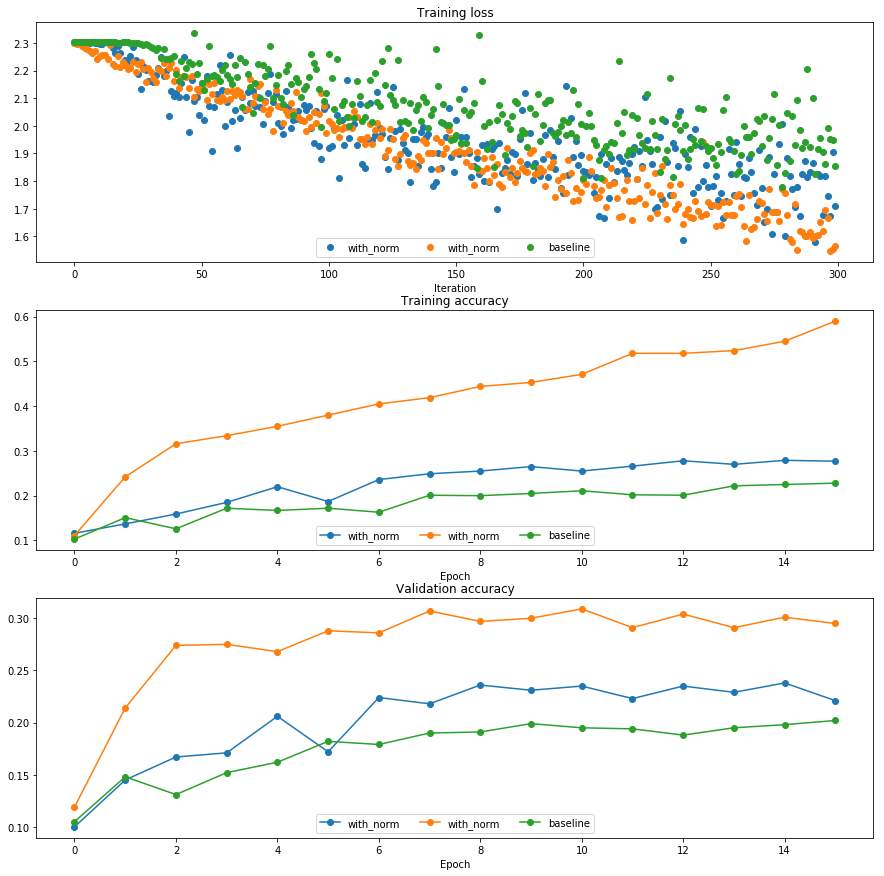

In [7]:
def plot_training_history(title, label, baseline, bn_solvers, plot_fn, bl_marker='.', bn_marker='.', labels=None):
    """utility function for plotting training history"""
    plt.title(title)
    plt.xlabel(label)
    bn_plots = [plot_fn(bn_solver) for bn_solver in bn_solvers]
    bl_plot = plot_fn(baseline)
    num_bn = len(bn_plots)
    for i in range(num_bn):
        label='with_norm'
        if labels is not None:
            label += str(labels[i])
        plt.plot(bn_plots[i], bn_marker, label=label)
    label='baseline'
    if labels is not None:
        label += str(labels[0])
    plt.plot(bl_plot, bl_marker, label=label)
    plt.legend(loc='lower center', ncol=num_bn+1) 

    
plt.subplot(3, 1, 1)
plot_training_history('Training loss','Iteration', bl_solver, [wn_solver, bn_solver], \
                      lambda x: x.loss_history, 'o', 'o')
plt.subplot(3, 1, 2)
plot_training_history('Training accuracy','Epoch', bl_solver, [wn_solver, bn_solver], \
                      lambda x: x.train_acc_history, '-o', '-o')
plt.subplot(3, 1, 3)
plot_training_history('Validation accuracy','Epoch', bl_solver, [wn_solver, bn_solver], \
                      lambda x: x.val_acc_history, '-o', '-o')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 1:
Describe the results of this experiment. What does this imply about the performance of weight normalization and batch normalization?

## Answer:

Weight normalization improves the training accuracy of the network and effectively serves as a regulator. The network trains faster than the vanilla baseline but not as quickly as a batch normalized version.

Weight normalization also improves over-fitting and achives better generalization and higher accuracy on the validation dataset.